In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import eli5

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import sklearn.metrics as metrics

from gensim import utils
import gensim.parsing.preprocessing as gsp

import joblib

from sklearn.decomposition import TruncatedSVD

from sklearn.dummy import DummyClassifier

# Functions

# Load data

In [2]:
# Read csv and create list of tags 
df = pd.read_csv('in/StackOverflow_50000_posts.csv')
df = df[['Id', 'Title', 'Body', 'Tags']]

df['Post'] = df['Title'] + ' ' + df['Body']
df.drop(columns = ['Title', 'Body'], inplace = True)

df['Tags'] = df['Tags'].str.findall(r'<(.*?)>')
df['nTags'] = df['Tags'].apply(len)

In [3]:
# df = df.loc[0:9999, :]
n_posts = df['Id'].count()

In [4]:
# Create tags matrix of size n_obs * n_tags
mlb = MultiLabelBinarizer(sparse_output = False)
df_tags = pd.DataFrame(mlb.fit_transform(df['Tags']), columns = mlb.classes_, index = df.index)

# Analyze tags

In [5]:
# Sort df_tags per number of occurences 
df_tags_unique = pd.DataFrame(df_tags.sum(axis = 0).sort_values(ascending = False), columns = ['n_occurence'])
df_tags = df_tags[df_tags_unique.index]

In [6]:
# Calculate cumulative percentage of tags
n_total_tags = df_tags.sum().sum()
df_tags_unique['pct_tags'] = df_tags_unique.cumsum(axis = 0) / n_total_tags * 100
n_total_tags

153341

In [7]:
# Calculate what % of posts are covered by at least one tag 
df_tmp = pd.DataFrame(index = df_tags.index, columns = ['Tagged'])
df_tmp['Tagged'] = 0

for col in df_tags:
    df_tmp['Tagged'] = df_tmp['Tagged'] | df_tags[col]
    df_tags_unique.loc[col, 'n_posts'] = df_tmp['Tagged'].sum()
    
df_tags_unique['pct_posts'] = df_tags_unique['n_posts'] / n_posts * 100

# Reset index to create tag col
df_tags_unique = df_tags_unique.reset_index().rename(columns = {'index': 'tag'})

n_tags_unique = df_tags_unique['tag'].count()
n_tags_unique

13379

In [8]:
df_tags_unique

,tag,n_occurence,pct_tags,n_posts,pct_posts
0,python,7619,4.968665,7619.0,15.238
1,javascript,5654,8.655872,13237.0,26.474
2,java,3604,11.006189,16796.0,33.592
3,c#,2722,12.781317,19460.0,38.920
4,html,2298,14.279938,20540.0,41.080
...,...,...,...,...,...
13374,modulus,1,99.997391,50000.0,100.000
13375,mojo-useragent,1,99.998044,50000.0,100.000
13376,mollie,1,99.998696,50000.0,100.000
13377,mongo-dart,1,99.999348,50000.0,100.000


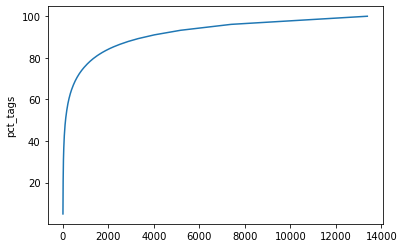

In [9]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_tags'])

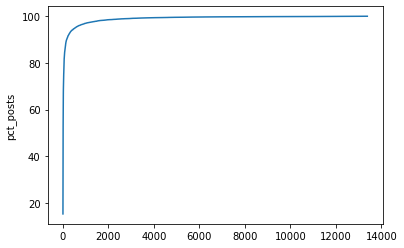

In [10]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_posts'])

In [11]:
df_tags_unique.loc[199, :]

tag            optimization
n_occurence              96
pct_tags            56.8485
n_posts               45464
pct_posts            90.928
Name: 199, dtype: object

# Modelling

## First subset of tags to limit the data set and get an unbiased test set

In [12]:
# Keep only the 200 most present tags and the associated posts in X and y
list_top = df_tags_unique.loc[0:199, 'tag']

df_tags = df_tags[list_top]

keep_index = df_tags[df_tags.sum(axis = 1) != 0].index

X = df.loc[keep_index, 'Post']
y = df_tags.loc[keep_index, :]

In [13]:
# Define a train and test set based on those tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, random_state = 0)

## Function to define tag and number of observations subset for train and val

In [14]:
def train_val_tag_subset(X_train, y_train, df_tags_unique, n_tags, n_train, n_val): 
    # Limit train and val to tag subset 
    list_top = df_tags_unique.loc[0:n_tags-1, 'tag']
    y_train = y_train[list_top]
    keep_index = y_train[y_train.sum(axis = 1) != 0].index
    X_train = X_train[keep_index]
    y_train = y_train.loc[keep_index, :]
    
    # Limit size of train and val
    X_train = X_train.sample(n = n_train + n_val, random_state = 55)
    y_train = y_train.loc[X_train.index, :]
    
    # Define validation set with a PredefinedSplit (for use in GridSearchCV)
    X_val = X_train.sample(n = n_val, random_state = 66)
    split_index = [0 if x in X_val.index else -1 for x in X_train.index]
    pds = PredefinedSplit(test_fold = split_index)
    
    return X_train, y_train, pds

## Pipeline

In [15]:
# Define and apply gensim filters
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
#            gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

# Custom transformer using gensim filters
class TextCleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

## First model, using max_df to limit number of features

In [16]:
X_train_1, y_train_1, pds_1 = train_val_tag_subset(X_train, y_train, df_tags_unique, n_tags = 80, n_train = 8000, n_val = 1000)

In [26]:
pd.DataFrame(y_train.columns, columns = ['tag']).to_csv('supervised_model_maxdf_tags.csv', sep = ';', index = False)

In [17]:
model = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs = -1, random_state = 457)

# XGBoost
n_estimators_xgb = [100]
max_depth_xgb = [5]
learning_rate_xgb = [0.1]
gamma_xgb = [0]
reg_lambda_xgb = [1]

param_grid = {
     'vect__min_df': [0.01], 
     'vect__max_df': [0.2],
#      'tsvd__n_components': [200, 500, 1000],
     'model__classifier__n_estimators': n_estimators_xgb,
     'model__classifier__max_depth': max_depth_xgb, 
     'model__classifier__learning_rate': learning_rate_xgb, 
     'model__classifier__gamma': gamma_xgb, 
     'model__classifier__reg_lambda': reg_lambda_xgb
    }

clf = BinaryRelevance(classifier = model, require_dense = [True, True])

pip = Pipeline([('clean', TextCleaner()),
                ('vect', TfidfVectorizer()),
#                 ('tsvd', TruncatedSVD()), 
                ('model', clf)])

pip_cv = GridSearchCV(pip, param_grid, cv = pds_1, scoring = 'jaccard_weighted', iid = False)

In [18]:
%%time 

pip_cv.fit(X_train_1, y_train_1)

print('Model :', model)
print('Cross Validation best score :', pip_cv.best_score_)
print('Cross Validation best params :', pip_cv.best_params_)

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


OSError: [WinError -529697949] Windows Error 0xe06d7363

In [ ]:
joblib.dump(pip_cv, 'supervised_model_maxdf.pkl')

In [18]:
pip_cv = joblib.load('supervised_model_maxdf.pkl')

In [19]:
y_proba = pip_cv.predict_proba(X_test)
y_proba = pd.DataFrame(y_proba.toarray(), columns = y_train_1.columns, index = y_test.index)

fill_columns = y_test.columns.difference(y_train_1.columns, sort = False)

y_fill = pd.DataFrame(index = y_test.index, columns = fill_columns).fillna(0)

In [20]:
jaccard_max = 0
f1_max = 0
decision_threshold_max = 0

for i in np.arange(0, 10, 1):
    decision_threshold = i / 10
    print('decision_threshold :', decision_threshold)
    
    y_pred = (y_proba > decision_threshold).replace({True: 1}).astype(np.int32)
    y_pred = y_pred.join(y_fill)

    jaccard = metrics.jaccard_score(y_test, y_pred, average = 'weighted')
    print('jaccard :', jaccard)

    if jaccard > jaccard_max:
        jaccard_max = jaccard
        f1_max = metrics.f1_score(y_test, y_pred, average = 'weighted')
        decision_threshold_max = decision_threshold

print('\n\nTest results :')
print('Jaccard :', jaccard_max)
print('F1 :', f1_max)
print('decision_threshold :', decision_threshold_max)
print()

decision_threshold : 0.0
jaccard : 0.04191715060209561


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


decision_threshold : 0.1
jaccard : 0.38515511526721385
decision_threshold : 0.2
jaccard : 0.40853750572736197
decision_threshold : 0.3
jaccard : 0.40248276228607294
decision_threshold : 0.4
jaccard : 0.3878336890706593
decision_threshold : 0.5
jaccard : 0.3724415459525463
decision_threshold : 0.6
jaccard : 0.35153665180316057
decision_threshold : 0.7
jaccard : 0.3220059463579131
decision_threshold : 0.8
jaccard : 0.27976061517112577
decision_threshold : 0.9
jaccard : 0.2043277130582788


Test results :
Jaccard : 0.40853750572736197
F1 : 0.5236360741564525
decision_threshold : 0.2



## Second model using TruncatedSVD

In [16]:
X_train_2, y_train_2, pds_2 = train_val_tag_subset(X_train, y_train, df_tags_unique, n_tags = 150, n_train = 10000, n_val = 5000)

In [17]:
model = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs = -1, random_state = 457)

# XGBoost
n_estimators_xgb = [100]
max_depth_xgb = [5]
learning_rate_xgb = [0.1]
gamma_xgb = [0]
reg_lambda_xgb = [1]

param_grid = {
#      'vect__min_df': [0.01], 
#      'vect__max_df': [0.2, 0.5, 0.7],
     'tsvd__n_components': [200],
     'model__classifier__n_estimators': n_estimators_xgb,
     'model__classifier__max_depth': max_depth_xgb, 
     'model__classifier__learning_rate': learning_rate_xgb, 
     'model__classifier__gamma': gamma_xgb, 
     'model__classifier__reg_lambda': reg_lambda_xgb
    }

clf = BinaryRelevance(classifier = model, require_dense = [True, True])

pip = Pipeline([('clean', TextCleaner()),
                ('vect', TfidfVectorizer()),
                ('tsvd', TruncatedSVD()), 
                ('model', clf)])

pip_cv = GridSearchCV(pip, param_grid, cv = pds_2, scoring = 'jaccard_weighted', iid = False)

In [18]:
%%time 

pip_cv.fit(X_train_2, y_train_2)

print('Model :', model)
print('Cross Validation best score :', pip_cv.best_score_)
print('Cross Validation best params :', pip_cv.best_params_)

Model : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=457,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Cross Validation best score : 0.29212957360232794
Cross Validation best params : {'model__classifier__gamma': 0, 'model__classifier__learning_rate': 0.1, 'model__classifier__max_depth': 5, 'model__classifier__n_estimators': 100, 'model__classifier__reg_lambda': 1, 'tsvd__n_components': 200}
Wall time: 31min 47s


In [ ]:
joblib.dump(pip_cv, 'supervised_model_tsvd.pkl')

In [74]:
pip_cv = joblib.load('supervised_model_tsvd.pkl')

In [19]:
y_proba = pip_cv.predict_proba(X_test)
y_proba = pd.DataFrame(y_proba.toarray(), columns = y_train_2.columns, index = y_test.index)

fill_columns = y_test.columns.difference(y_train_2.columns, sort = False)

y_fill = pd.DataFrame(index = y_test.index, columns = fill_columns).fillna(0)

In [20]:
jaccard_max = 0
f1_max = 0
decision_threshold_max = 0

for i in np.arange(0, 10, 1):
    decision_threshold = i / 10
    print('decision_threshold :', decision_threshold)
    
    y_pred = (y_proba > decision_threshold).replace({True: 1}).astype(np.int32)
    y_pred = y_pred.join(y_fill)

    jaccard = metrics.jaccard_score(y_test, y_pred, average = 'weighted')
    print('jaccard :', jaccard)

    if jaccard > jaccard_max:
        jaccard_max = jaccard
        f1_max = metrics.f1_score(y_test, y_pred, average = 'weighted')
        decision_threshold_max = decision_threshold

print('\n\nTest results :')
print('Jaccard :', jaccard_max)
print('F1 :', f1_max)
print('decision_threshold :', decision_threshold_max)
print()

decision_threshold : 0.0
jaccard : 0.042403263306052236


C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


decision_threshold : 0.1
jaccard : 0.34654615934280386
decision_threshold : 0.2
jaccard : 0.3559188409840578
decision_threshold : 0.3
jaccard : 0.3400249140309231
decision_threshold : 0.4
jaccard : 0.3187508726371892
decision_threshold : 0.5
jaccard : 0.2898049974004779
decision_threshold : 0.6
jaccard : 0.2584319777475951
decision_threshold : 0.7
jaccard : 0.22094427727677937
decision_threshold : 0.8
jaccard : 0.17842240460500572
decision_threshold : 0.9
jaccard : 0.12313069963747353


Test results :
Jaccard : 0.3559188409840578
F1 : 0.4882707798289704
decision_threshold : 0.2



## Dummy model for comparison

In [66]:
dum_clf = DummyClassifier(strategy = 'uniform', random_state = 541)
dum_clf.fit(X_train, y_train)
y_pred_dum = dum_clf.predict(X_test)

print('jaccard :', metrics.jaccard_score(y_test, y_pred_dum, average = 'weighted'))
print('f1 :', metrics.f1_score(y_test, y_pred_dum, average = 'weighted'))
print('accuracy :', metrics.accuracy_score(y_test, y_pred_dum))
print('hamming :', metrics.hamming_loss(y_test, y_pred_dum))

jaccard : 0.038886796646192795
f1 : 0.07172947876232016
accuracy : 0.0
hamming : 0.499604


# Load trained model

In [14]:
pip_cv = joblib.load('supervised_model.pkl')

In [18]:
print('Model :', pip_cv.best_estimator_['model'])
print('Cross Validation best score :', pip_cv.best_score_)
print('Cross Validation best params :', pip_cv.best_params_)

# Get results on test set
y_proba = pip_cv.predict_proba(X_test)
y_proba = pd.DataFrame(y_proba.toarray(), columns = y_test.columns, index = y_test.index)

jaccard_max = 0
f1_max = 0
decision_threshold_max = 0

for i in np.arange(0, 10, 1):
    decision_threshold = i / 10

    jaccard = metrics.jaccard_score(y_test, y_proba > decision_threshold, average = 'weighted')

    if jaccard > jaccard_max:
        jaccard_max = jaccard
        f1_max = metrics.f1_score(y_test, y_proba > decision_threshold, average = 'weighted')
        decision_threshold_max = decision_threshold

print('Test results :')
print('Jaccard :', jaccard_max)
print('F1 :', f1_max)
print('decision_threshold :', decision_threshold_max)
print()

Model : BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster='gbtree',
                                         colsample_bylevel=1,
                                         colsample_bynode=1, colsample_bytree=1,
                                         gamma=1, learning_rate=0.1,
                                         max_delta_step=0, max_depth=10,
                                         min_child_weight=1, missing=nan,
                                         n_estimators=100, n_jobs=-1,
                                         nthread=None,
                                         objective='binary:logistic',
                                         random_state=457, reg_alpha=0,
                                         reg_lambda=1, scale_pos_weight=1,
                                         seed=None, silent=None, subsample=1,
                                         verbosity=1),
                require_dense=[True, True])
Cross Validation best score : 0.4748736

# Mesure model performance

In [67]:
jaccard = pd.DataFrame(metrics.jaccard_score(y_test, y_proba > decision_threshold_max, average = None), 
                       index = y_test.columns, columns = ['base'])
jaccard

ValueError: Multi-label binary indicator input with different numbers of labels

# Analyze model

In [20]:
pip_cv.best_estimator_['model']

BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster='gbtree',
                                         colsample_bylevel=1,
                                         colsample_bynode=1, colsample_bytree=1,
                                         gamma=1, learning_rate=0.1,
                                         max_delta_step=0, max_depth=10,
                                         min_child_weight=1, missing=nan,
                                         n_estimators=100, n_jobs=-1,
                                         nthread=None,
                                         objective='binary:logistic',
                                         random_state=457, reg_alpha=0,
                                         reg_lambda=1, scale_pos_weight=1,
                                         seed=None, silent=None, subsample=1,
                                         verbosity=1),
                require_dense=[True, True])

In [21]:
vocab = pip_cv.best_estimator_['vect'].get_feature_names()

In [22]:
vocab[0:40]

['aa',
 'aaa',
 'aaaa',
 'aac',
 'aad',
 'aaeb',
 'aattgg',
 'ab',
 'abacad',
 'abafac',
 'abandon',
 'abc',
 'abcd',
 'abcdefghijklmnopqrstuvwxyz',
 'abd',
 'abecf',
 'abhol',
 'abholdatum',
 'abhorr',
 'abi',
 'abil',
 'abl',
 'abnorm',
 'aboolean',
 'abort',
 'aborterror',
 'abortexcept',
 'absent',
 'absente',
 'absl',
 'absolut',
 'absolutei',
 'absolutex',
 'absorb',
 'absteigend',
 'abstract',
 'abstractapplicationcontext',
 'abstractautowirecapablebeanfactori',
 'abstractbaseus',
 'abstractbeanfactori']

In [23]:
list_top

0         python
1     javascript
2           java
3              r
4             c#
5            c++
6        android
7     python-3.x
8            php
9           html
10        pandas
11       reactjs
12           sql
13       laravel
14           css
15         mysql
16             c
17       angular
18     dataframe
19        arrays
Name: tag, dtype: object

In [77]:
tag_number = 6
print('Tag :', y_train.columns[tag_number])
eli5.show_weights(pip_cv.best_estimator_['model'].classifiers_[tag_number], vec = pip_cv.best_estimator_['vect'], top = 15)

Tag : c++


Weight,Feature
0.0968,std
0.0336,cout
0.0182,df
0.0172,iostream
0.0129,compil
0.0125,pointer
0.0120,int
0.0120,constructor
0.0117,packag
0.0115,const
